# A Clean Version of the MPC Implementation

Contains results for training the convolutional model with the MPC

### Imports

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from keras.models import Model
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import sys

import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2, denorm_loss, hinge_mse_loss, percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
import helpers
from tqdm import tqdm

### Load Files and Model

In [3]:
# # 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl'
os.chdir(os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_03_10/'))
files = [foo for foo in os.listdir() if 'Scenario-265.h5' in foo]
print("Matching files at {} are : {}".format(os.getcwd(),files))

Matching files at /projects/EKOLEMEN/profile_predictor/run_results_03_10 are : ['model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5']


### Helpers

In [4]:
def get_AB(model):
    # Extract A, B from Autoencoder model
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

def get_submodels(model):
    # Get all relevant layers
    
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    return state_encoder, state_decoder, control_encoder

def get_control_decoder_matrices(control_encoder):
    # Figure out control decoder matrices
    
    A1 = control_encoder.layers[5].get_weights()[0]
    A2 = control_encoder.layers[6].get_weights()[0]
    B1 = control_encoder.layers[5].get_weights()[1]
    B2 = control_encoder.layers[6].get_weights()[1]
    
    A1 = np.linalg.inv(A1)
    A2 = np.linalg.inv(A2)
    
    return A1, A2, B1, B2

def decode_control(A1, A2, B1, B2, u_enc):
    # decode control inputs given control decoder matrices
    
    u_dec = []
    for elem in u_enc:
        u = A2 @ (elem - B2)
        u = A1 @ (u - B1)      
        u_dec.append(u)
    return np.array(u_dec)


def get_state_and_inputs(scenario,inputs,**kwargs):
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    return x0, control_inputs, state_inputs

def encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs,**kwargs):
    # encode control
    T = scenario['lookahead']
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
        
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    return x0, u

def encode_state(state_encoder, x0):
    return np.squeeze(state_encoder.predict(x0))

def decode_state(state_decoder,x):
    return state_decoder.predict(x[np.newaxis,:])


def decode_inputs(control_decoder, inputs):
    return control_decoder.predict(inputs)

def get_final_state(state_encoder,scenario,inputs,**kwargs):
    state_inputs = {}
    xf = {}
    for sig in scenario['target_profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,scenario['profile_length']))
        else:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,1))
    
    xf_enc = np.squeeze(state_encoder.predict(xf))
    return xf, xf_enc

def get_state_predictions(scenario,x_dec):
    state_predictions = {}
    for i, sig in enumerate(scenario['target_profile_names']):
        state_predictions[sig] = np.squeeze(x_dec[0][i*33:(i+1)*33])
#     print("x_dec: {}".format(x_dec))
#     print("state_pred: {}".format(state_predictions))
    return state_predictions

def mean_squared_error(true,pred):
    return np.mean((true-pred)**2)

def mean_absolute_error(true,pred):
    return np.mean(np.abs(true-pred))

def median_absolute_error(true,pred):
    return np.median(np.abs(true-pred))

def percentile25_absolute_error(true,pred):
    return np.percentile(np.abs(true-pred),25)

def percentile75_absolute_error(true,pred):
    return np.percentile(np.abs(true-pred),75)

def median_squared_error(true,pred):
    return np.median((true-pred)**2)

def percentile25_squared_error(true,pred):
    return np.percentile((true-pred)**2,25)

def percentile75_squared_error(true,pred):
    return np.percentile((true-pred)**2,75)

def huber_error(true,pred):
    return np.mean(np.where(np.abs(pred-true) < 0.7, 0.5*(pred - true)**2, 0.7*(np.abs(pred-true)-0.5*0.7)))

In [5]:

################# Models ################################

### Run Results 04_10
# Model 7 (layer scale = 2)
# model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7.h5'
# scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7_params.pkl'

# Model 2 (layer scale = 1)
# model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2.h5'
# scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2_params.pkl'

# Model 2 with lookahead = 4
# model_path = '/home/aiqtidar/run_results_04_12/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_13Apr21-16-43_Scenario-0.h5'
# scenario_path = '/home/aiqtidar/run_results_04_12/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_13Apr21-16-43_Scenario-0_params.pkl'

# Aaron's Best Model
# model_path = '/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10.h5'
# scenario_path ='/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10_params.pkl'

# Aaron's Ideal Hyperparam
scenario_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0_params.pkl'
model_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0.h5'


# Load Model
model = keras.models.load_model(model_path, compile=False)
with open(scenario_path, 'rb') as f:
    scenario_auto = pickle.load(f, encoding='latin1')

    
A,B = get_AB(model)
state_encoder, state_decoder, control_encoder = get_submodels(model)
A1_inv, A2_inv, B1, B2 = get_control_decoder_matrices(control_encoder)

print("A: " + str(A.shape))
print("B: " + str(B.shape))

# Ideal Convolutional Model
model = keras.models.load_model('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5', compile=False)
with open('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')


W0428 09:36:13.048993 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0428 09:36:13.088936 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0428 09:36:13.313406 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  war

A: (70, 70)
B: (70, 4)


### Prepare Data

In [6]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)

%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}


orig_data_path = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 0,
                                                      uncertainties=True)
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
valdata = helpers.normalization.renormalize(helpers.normalization.denormalize(valdata.copy(),normalization_dict),scenario['normalization_dict'])

data_generator_batch = DataGenerator(valdata,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None)

Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  5551
Number of shots used:  5551
Total number of timesteps:  582795
Shots with Complete NaN: 
394389 samples total
Removing ECH
Removed 167477 samples
226912 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 43708 samples
183204 samples remaining
Removing weird I-coils
Removed 40583 samples
142621 samples remaining
Removing NaN
Removed 0 samples
142621 samples remaining
Removing dudtrip
Removed 8101 samples
134520 samples remaining
134520 samples remaining after pruning


Denormalizing:  22%|##2       | 6/27 [00:00<00:00, 58.74it/s]

Total number of samples:  134520
Number of training samples:  121324
Number of validation samples:  13196


Normalizing: 100%|##########| 27/27 [00:00<00:00, 119.58it/s]


### Define Encoders and Decoders

In [7]:
model = keras.models.load_model('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5', compile=False)
with open('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')


/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
#projects/EKOLEMEN/profile-predictor/aiqtidar

In [8]:
# Make Predictions
predictions_arr = np.array(model.predict_generator(data_generator_batch,verbose=1))
predictions = {sig: arr for sig, arr in zip(scenario['target_profile_names'],predictions_arr)}

104/104 [==============================] - 24s 233ms/step


In [9]:
### Use model.predict to get a prediction

def predict_model(i, umpc = None): 
    # Predicts on the i-th dataset of the data_generator_batch variable
    # set umpc to the mpc inputs, otherwise set to null to default to real inputs from the data generator
    
    inp = []

    for sig in scenario['target_profile_names']:
        inp.append((data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)].reshape((1,1,scenario['profile_length']))))

    for sig in scenario['actuator_names']:
        inp.append((np.array(([np.transpose(data_generator_batch[int(i/128)][0]['input_past_' + sig][int(i % 128)])]))))

    for sig in scenario['actuator_names']:
        if umpc is not None:
            inp.append(umpc)
        else:
            inp.append(np.array(([np.transpose(data_generator_batch[int(i/128)][0]['input_future_' + sig][int(i % 128)])])))

    for sig in scenario['scalar_input_names']:
        inp.append((data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)].reshape((1,7))))
    return np.array(model.predict(inp))

In [10]:
scenario['target_profile_names']

['dens', 'temp', 'q_EFIT01', 'rotation', 'press_EFIT01']

In [11]:
scenario['actuator_names']

['target_density', 'pinj', 'tinj', 'curr_target']

In [12]:
scenario['lookahead']

4

### Finalize Data

Creates a new set of variables which are more readable

In [13]:
model = keras.models.load_model(model_path, compile=False)
A,B = get_AB(model)
state_encoder, state_decoder, control_encoder = get_submodels(model)

model = keras.models.load_model('/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5', compile=False)

In [14]:
###################### Get inital state and actuator inputs ready ######################

X_F_conv_tot = [] # Final state predicted by conv model
X_F_real_tot = [] # Final real state
X_F_enc_tot = [] # Final real state encoded
X_0_tot = [] # Initial state
u_tot = [] # control inputs
X_0_enc_tot = [] # Initial state encoded
u_enc_tot = [] # Encoded control inputs
state_inputs_arr = [] # Contains profiles, for both initial and final state

for i in range(0, predictions_arr.shape[1]):
    print("Completed {} of {}".format(i,predictions_arr.shape[1]),end='\r')
    
    # Get initial profile array
    x0 = {}
    state_inputs = {}
    for sig in scenario['target_profile_names']:
        x0['input_' + sig] = data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)].reshape((1,1,scenario['profile_length']))
        xf_real = data_generator_batch[int(i/128)][1]['target_' + sig][int(i % 128)].reshape((1,1,scenario['profile_length']))
        state_inputs['input_' + sig] = np.array([x0['input_' + sig], xf_real])
        
    for sig in scenario['scalar_input_names']:
        x0['input_' + sig] = data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)][0].reshape((1,1,1))
    
    # Get control inputs array
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = np.array(([np.transpose(data_generator_batch[int(i/128)][0]['input_future_' + sig][int(i % 128)] [np.newaxis])]))
    
    # Get target state
    X_F = {}
    X_F_real = {}
    for profile in scenario['target_profile_names']:
        X_F['input_' + profile] = np.array([[predictions[profile][i]]])
        X_F_real['input_' + profile] = state_inputs['input_' + profile][-1]

    for sig in scenario['scalar_input_names']:
        X_F_real['input_' + sig] = data_generator_batch[int(i/128)][0]['input_' + sig][int(i % 128)][-1].reshape((1,1,1))
    
    
    
#     print("x0: {}".format(x0.keys()))
#     print("u: {}".format(control_inputs['input_target_density'].shape))
#     print("u: {}".format(control_inputs['input_target_density']))
    
    x_enc, u_enc = encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs)
    
    X_F_real_tot.append(X_F_real)
    X_F_enc_tot.append(encode_state(state_encoder, X_F_real))
    X_F_conv_tot.append(X_F)
    X_0_tot.append(x0)
    u_tot.append(control_inputs)    
    X_0_enc_tot.append(x_enc)
    u_enc_tot.append(u_enc)
    state_inputs_arr.append(state_inputs)
    

In [15]:
# Convert to Numpy Arrays
X_F_real_tot = np.array(X_F_real_tot)
X_F_enc_tot = np.array(X_F_enc_tot)
X_F_conv_tot = np.array(X_F_conv_tot)
X_0_tot = np.array(X_0_tot)
u_tot = np.array(u_tot)
X_0_enc_tot = np.array(X_0_enc_tot)
u_enc_tot = np.array(u_enc_tot)

# print("X_F_tot.shape: {}".format(X_F_tot.shape))
print("X_0_tot.shape: {}".format(X_0_tot.shape))
print("u_tot.shape: {}".format(u_tot.shape))
print("X_0_enc_tot.shape: {}".format(X_0_enc_tot.shape))
print("u_enc_tot.shape: {}".format(u_enc_tot.shape))

X_0_tot.shape: (13196,)
u_tot.shape: (13196,)
X_0_enc_tot.shape: (13196, 70)
u_enc_tot.shape: (13196, 4, 4)


## Manually Propagate SSS

### Use the True Future Control Inputs

In [28]:
def get_model_prediction(x0, control_inputs, u_mpc, A, B, n):
    # Helper function for get_conv
    # returns real and mpc predictions for some initial state x0, given some A,B, control_inputs, mpc_inputs and number of timesteps n
    # u_mpc and control_inputs can be set to none to avoid predictions respectively
    
    
    state_pred_arr = []
    mpc_pred_arr = []
    x_mpc = x0
    # Propagate through model
    for i in range(0, n):
        if (control_inputs is not None):
            x0 = (x0 @ A.T  + control_inputs[i] @ B.T)
            state_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x0)))
        if (u_mpc is not None):
            x_mpc = (x_mpc @ A.T  + u_mpc[i] @ B.T)
            mpc_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x_mpc)))

    # print("State_predictions: {}".format(state_predictions))
    return state_pred_arr, mpc_pred_arr

# Plotting
def generate_profile_plots(state_predictions, mpc_predictions, conv_predictions, state_inputs, profiles, filtered = False, mpc_filtered = False, conv_filtered = False, conv_with_mpc = False):
    # Simply plots data given predictions
    # state_inputs contains the set of true data
    # Any set of predictions can be "turned off" by setting to null
    # Uses the butterworth filter by default, filter is optional (depends on the boolean variables)
    
    
    shotnum = data_generator_batch.cur_shotnum[0,0]
    shottime = data_generator_batch.cur_times[0,-scenario['lookahead']-1]
    psi = np.linspace(0,1,scenario['profile_length'])

    fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
    for j, profile in enumerate(profiles):
        ax = axes[j]

        inp_norm = state_inputs['input_' + profile][0].squeeze()
        true_norm = inp_norm + state_inputs['input_' + profile][-1].squeeze()
        
        inp = helpers.normalization.denormalize_arr(inp_norm,scenario['normalization_dict'][profile])
        true = helpers.normalization.denormalize_arr(true_norm,scenario['normalization_dict'][profile])
        
        ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
        ax.plot(psi,true,lw=1.5,label='True, time $t+200$ms',c='k',ls=':')
        
        if (state_predictions is not None):
            if (filtered == True):
                pred = butter_lowpass_filtfilt(state_predictions['input_' + profile].squeeze(), cutoff, fs)
            else:
                pred = (state_predictions[profile].squeeze())
            pred = helpers.normalization.denormalize_arr(pred,scenario_auto['normalization_dict'][profile])
            ax.plot(psi,pred,lw=1.5,label='Autoencoder Prediction, time $t+200$ms',c=colorblind_colors[0])
        
        if (mpc_predictions is not None):
            if (mpc_filtered == True):
                mpc_pred = butter_lowpass_filtfilt(mpc_predictions[profile].squeeze(), cutoff, fs)
            else:
                mpc_pred = (mpc_predictions[profile].squeeze())
            mpc_pred = helpers.normalization.denormalize_arr(mpc_pred,scenario_auto['normalization_dict'][profile])
            ax.plot(psi,mpc_pred,lw=1.5,label='MPC Prediction, time $t+200$ms',c=colorblind_colors[2])
        
        if (conv_predictions is not None):
            if (conv_filtered == True):
                conv_pred = butter_lowpass_filtfilt(conv_predictions[profile].squeeze(), cutoff, fs)
            else:
                conv_pred = inp_norm + (conv_predictions[profile].squeeze())
            conv_pred = helpers.normalization.denormalize_arr(conv_pred,scenario['normalization_dict'][profile])
        if conv_with_mpc == True:
            ax.plot(psi,conv_pred,lw=1.5,label='Convolutional Model Prediction with MPC inputs, time $t+200$ms',c=colorblind_colors[0])
        else:
            ax.plot(psi,conv_pred,lw=1.5,label='Convolutional Model Prediction, time $t+200$ms',c=colorblind_colors[0])


        ax.set_ylabel(labels[profile],size=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

        if j in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if j in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
    fig.align_ylabels(axes)
    plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
    fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
    fig.legend(handles=axes[0].lines,     
               labels=[line._label for line in axes[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.12),
               frameon=False,
               mode=None,
               ncol=1,
              fontsize=8)

### Set up system
def get_conv(index, plot = False, filtered = False, mpc_filtered = False, conv_filtered = False):
    # Contains only convolutional model predictions and autoencoder predictions with mpc inputs
    # Gets all predictions and true values for dataset at index
    # Plotting and filters are optional
    
    
    n = scenario['lookahead']
    profiles = scenario['target_profile_names']
    temp_x = X_0_enc_tot[index]
    temp_u = u_enc_tot[index]
    temp_xf = X_F_enc_tot[index]

    ### Build Conv Model Predictions
    conv_pred_profiles = {}
    for sig in scenario['target_profile_names']:
        conv_pred_profiles[sig] = predictions[sig][index]

    #### Get MPC Solution

    N = temp_x.shape[0]
    M = u_enc_tot.shape[2]

    # Generate Q,R
    Q = np.eye(N)*1e-5
    R = np.eye(M)*1e3

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,temp_xf,n)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc = sol_mpc.reshape(n, M)
    temp_u_mpc = u_mpc

    # mpc_pred = None

    #### Call functions to generate plots

    state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)
    # Plot everything
    # generate_profile_plots(state_pred[n-1], mpc_pred[-1], conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)
    
    if plot == True:
        generate_profile_plots(None, None, conv_pred_profiles, state_inputs_arr[index], profiles, filtered, mpc_filtered, conv_filtered, conv_with_mpc = False)
    return state_pred, mpc_pred, conv_pred_profiles

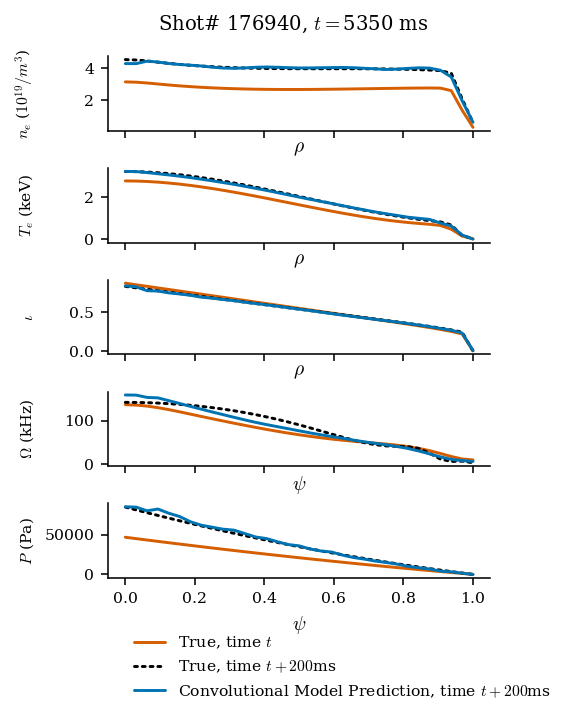

In [29]:
state_pred, mpc_pred, conv_pred_profiles = get_conv(150, plot = True);

### Use the MPC Control Inputs

In [30]:
def gen_conv_mpc(index, plot = False):
    # Contains convolutional model predictions with mpc inputs instead of just convolutional model predictions
    # Gets all predictions and true values for dataset at index
    # Plotting and filters are optional
    
    ### Set up system
    n = scenario['lookahead']
    profiles = scenario['target_profile_names']
    temp_x = X_0_enc_tot[index]
    temp_u = u_enc_tot[index]
    temp_xf = X_F_enc_tot[index]


    #### Get MPC Solution

    N = temp_x.shape[0]
    M = u_enc_tot.shape[2]

    # Generate Q,R
    Q_scale = 1e5
    R_scale = 1e-10
    
    Q = np.eye(N)
    R = np.eye(M)
    Q = np.eye(N)*Q_scale
    R = np.eye(M)*R_scale

    n_prime = n

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,temp_xf,n_prime, lim = 2)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc = sol_mpc.reshape(n_prime, M)
    temp_u_mpc = u_mpc

    ### Build Conv Model Predictions
    conv_pred_profiles = {}
    for i, sig in enumerate(scenario['target_profile_names']):
        conv_pred_profiles[sig] = np.squeeze(predict_model(i, umpc = temp_u_mpc)[i])

    #### Call functions to generate plots

    state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)
    
    # Include autoencoder and MPC predictions
    # generate_profile_plots(state_pred[n-1], mpc_pred[-1], conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)
    
    if plot == True:
        generate_profile_plots(None, None, conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False,conv_with_mpc = True)
    return state_pred, mpc_pred, conv_pred_profiles

# def gen_conv_mpc_ramped(index, ramp_factor = 1.25, lim = 2, plot = False):
#     ### Set up system
#     n = scenario['lookahead']
#     profiles = scenario['target_profile_names']
#     temp_x = X_0_enc_tot[index]
#     temp_xf = temp_x * ramp_factor
#     temp_xf_decoded = decode_state(state_decoder, temp_xf)
    
#     # Generate the state_inputs array (for input and true profiles)
#     temp_state_inputs = {}
#     for i,profile in enumerate(profiles):
#         temp_state_inputs['input_' + profile] = [state_inputs['input_' + profile][0].squeeze(), temp_xf_decoded[0][(i*33):((i+1)*33)]]
# #         print(temp_xf_decoded[(i*33):((i+1)*33)])
#     print(temp_xf_decoded.shape)
# #     print(temp_state_inputs)
    
#     #### Get MPC Solution

#     N = temp_x.shape[0]
#     M = u_enc_tot.shape[2]

#     # Generate Q,R
#     Q_scale = 1e1
#     R_scale = 1e-5
    
#     Q = np.eye(N)
#     R = np.eye(M)
#     Q = np.eye(N)*Q_scale
#     R = np.eye(M)*R_scale

#     n_prime = n

#     sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,temp_xf,n_prime, lim = lim)
#     sol_mpc = np.array(sol_mpc['x'])
#     u_mpc = sol_mpc.reshape(n_prime, M)
#     temp_u_mpc = u_mpc
    
# #     print(temp_u_mpc)
    
#     ### Build Conv Model Predictions
#     conv_pred_profiles = {}
#     for i, sig in enumerate(scenario['target_profile_names']):
#         conv_pred_profiles[sig] = np.squeeze(predict_model(i, umpc = temp_u_mpc)[i])

#     #### Call functions to generate plots

#     state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)
#     # generate_profile_plots(state_pred[n-1], mpc_pred[-1], conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)
#     if plot == True:
#         generate_profile_plots(None, None, conv_pred_profiles, temp_state_inputs, profiles, filtered = False)
#     return state_pred, mpc_pred, conv_pred_profiles


def gen_conv_mpc_ramped(index, ramp_factor = 1.25, lim = 2, plot = False):
    # This function is broken. It was supposed to make predictions on the initial profile ramped up by a factor
    # Ramping up is incorrect because of some normalization issues
    # Due to time constraints on my thesis, never got around to fixing it.
    # Fixing it should be easy though
    
    
    ### Set up system
    n = scenario['lookahead']
    profiles = scenario['target_profile_names']
    temp_x = X_0_enc_tot[index]
    
#     helpers.normalization.denormalize_arr(true_norm,scenario['normalization_dict'][profile])
    
    temp_xf_real = {}
    for profile in (profiles):
        temp_denorm_x0 = helpers.normalization.denormalize_arr(X_0_tot[index]['input_'+ profile],scenario['normalization_dict'][profile])
        temp_xf_real['input_'+ profile] = helpers.normalization.renormalize(temp_denorm_x0*(ramp_factor - 1),scenario['normalization_dict'][profile])
#         print(temp_denorm_x0)
#         print(helpers.normalization.denormalize_arr(temp_xf_real['input_'+ profile],scenario['normalization_dict'][profile]))
    
    for profile in (scenario_auto['scalar_names']):
        temp_xf_real['input_'+ profile] = X_0_tot[index]['input_'+ profile] # For now, keep scalar names the same
    
        
    # Generate the state_inputs array (for input and true profiles)
    temp_state_inputs = {}
    for i,profile in enumerate(profiles):
        temp_state_inputs['input_' + profile] = [X_0_tot[index]['input_'+ profile], temp_xf_real['input_'+ profile]]
    
#     print(temp_state_inputs['input_dens'])
#     print(helpers.normalization.denormalize_arr(temp_state_inputs['input_dens'][0],scenario['normalization_dict'][profile]))
#     print(helpers.normalization.denormalize_arr(temp_state_inputs['input_dens'][-1],scenario['normalization_dict'][profile]))
#     print(temp_xf_real)
    
    temp_xf = encode_state(state_encoder, temp_xf_real)
    
    #### Get MPC Solution

    N = temp_x.shape[0]
    M = u_enc_tot.shape[2]

    # Generate Q,R
    Q_scale = 1e1
    R_scale = 1e-5
    
    Q = np.eye(N)
    R = np.eye(M)
    Q = np.eye(N)*Q_scale
    R = np.eye(M)*R_scale

    n_prime = n

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,temp_xf,n_prime, lim = lim)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc = sol_mpc.reshape(n_prime, M)
    temp_u_mpc = u_mpc
    
#     print(temp_u_mpc)
    
    ### Build Conv Model Predictions
    conv_pred_profiles = {}
    for i, sig in enumerate(scenario['target_profile_names']):
        conv_pred_profiles[sig] = np.squeeze(predict_model(i, umpc = temp_u_mpc)[i])

    #### Call functions to generate plots

#     state_pred, mpc_pred = get_model_prediction(temp_x, temp_u, temp_u_mpc, A, B, n)
    # generate_profile_plots(state_pred[n-1], mpc_pred[-1], conv_pred_profiles, state_inputs_arr[index], profiles, filtered = False)
    if plot == True:
        generate_profile_plots(None, None, conv_pred_profiles, temp_state_inputs, profiles, filtered = False, conv_with_mpc = True)
    return state_pred, mpc_pred, conv_pred_profiles


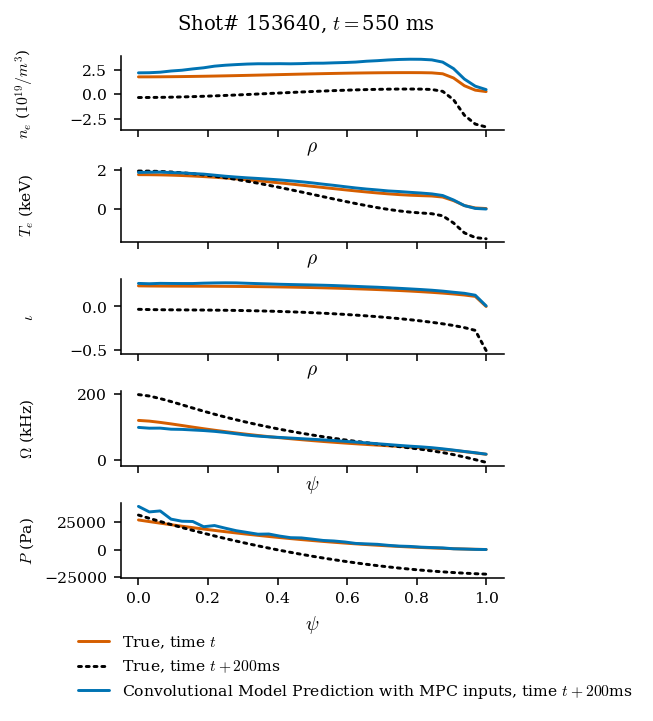

In [31]:
gen_conv_mpc_ramped(55, ramp_factor = 2, lim = 3, plot = True);

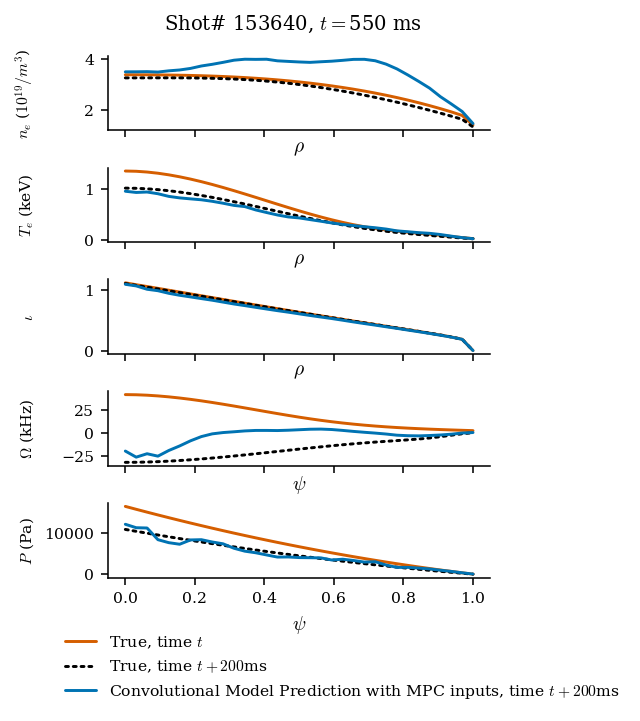

In [32]:
state_pred, mpc_pred, conv_pred_profiles = gen_conv_mpc(12914, True)

### Generate Statistics

In [ ]:
# Generates mass statistics
# Takes a while to run
# Stats are currently saved in saved_stats


# stats_conv_mpc_tot = []
# stats_conv_tot = []

# for i in range(0, len(X_0_tot)): #len(X_0_tot)
#     print("Completed {} of {}".format(i,len(X_0_tot)),end='\r')
    
#     state_pred, mpc_pred, conv_pred_profiles_mpc = gen_conv_mpc(i, plot = False)
#     _, _, conv_pred_profiles = get_conv(i, plot = False)
    
#     stats_conv_mpc = {}
#     mpc_mse = {}
#     mpc_mae = {}
#     mpc_meae = {}
#     mpc_p25ae = {}
#     mpc_p75ae = {}
#     mpc_mese = {}
#     mpc_p25se = {}
#     mpc_p75se = {}
#     mpc_he = {}
    
#     stats_conv = {}
#     mse = {}
#     mae = {}
#     meae = {}
#     p25ae = {}
#     p75ae = {}
#     mese = {}
#     p25se = {}
#     p75se = {}
#     he = {}
    
    
#     for i, profile in enumerate(scenario['target_profile_names']):
#         # True profile
#         true_norm = state_inputs_arr[i]['input_' + profile][0].squeeze() + state_inputs_arr[i]['input_' + profile][-1].squeeze()
#         true = helpers.normalization.denormalize_arr(true_norm,scenario['normalization_dict'][profile])

#         # Convolutional Model Predictions
#         # With MPC inputs
#         conv_pred_mpc = state_inputs_arr[i]['input_' + profile][0].squeeze()  + (conv_pred_profiles_mpc[profile].squeeze())
#         conv_pred_mpc = helpers.normalization.denormalize_arr(conv_pred_mpc,scenario['normalization_dict'][profile])
        
#         # Without MPC inputs
#         conv_pred = state_inputs_arr[i]['input_' + profile][0].squeeze()  + (conv_pred_profiles[profile].squeeze())
#         conv_pred = helpers.normalization.denormalize_arr(conv_pred,scenario['normalization_dict'][profile])
        
        
#         # Values for the conv_pred with mpc inputs
#         mse_val = mean_squared_error(true,conv_pred_mpc)
#         mae_val = mean_absolute_error(true,conv_pred_mpc)
#         meae_val = median_absolute_error(true,conv_pred_mpc)
#         p25ae_val = percentile25_absolute_error(true,conv_pred_mpc)
#         p75ae_val = percentile75_absolute_error(true,conv_pred_mpc)
#         mese_val = median_squared_error(true,conv_pred_mpc)
#         p25se_val = percentile25_squared_error(true,conv_pred_mpc)
#         p75se_val = percentile75_squared_error(true,conv_pred_mpc)
#         he_val = huber_error(true,conv_pred_mpc)
        
#         mpc_mse[profile] = mse_val
#         mpc_mae[profile] = mae_val
#         mpc_meae[profile] = meae_val
#         mpc_p25ae[profile] = p25ae_val
#         mpc_p75ae[profile] = p75ae_val
#         mpc_mese[profile] = mese_val
#         mpc_p25se[profile] = p25se_val
#         mpc_p75se[profile] = p75se_val
#         mpc_he[profile] = he_val
        
#         # Repeat for the conv profile
#         mse_val = mean_squared_error(true,conv_pred)
#         mae_val = mean_absolute_error(true,conv_pred)
#         meae_val = median_absolute_error(true,conv_pred)
#         p25ae_val = percentile25_absolute_error(true,conv_pred)
#         p75ae_val = percentile75_absolute_error(true,conv_pred)
#         mese_val = median_squared_error(true,conv_pred)
#         p25se_val = percentile25_squared_error(true,conv_pred)
#         p75se_val = percentile75_squared_error(true,conv_pred)
#         he_val = huber_error(true,conv_pred)
        
#         mse[profile] = mse_val
#         mae[profile] = mae_val
#         meae[profile] = meae_val
#         p25ae[profile] = p25ae_val
#         p75ae[profile] = p75ae_val
#         mese[profile] = mese_val
#         p25se[profile] = p25se_val
#         p75se[profile] = p75se_val
#         he = he_val  

        
#     stats_conv_mpc['mse'] = mpc_mse
#     stats_conv_mpc['mae'] = mpc_mae
#     stats_conv_mpc['meae'] = mpc_meae
#     stats_conv_mpc['p25ae'] = mpc_p25ae
#     stats_conv_mpc['p75ae'] = mpc_p75ae
#     stats_conv_mpc['mese'] = mpc_mese
#     stats_conv_mpc['p25se'] = mpc_p25se
#     stats_conv_mpc['p75se'] = mpc_p75se
#     stats_conv_mpc['he'] = mpc_he
#     stats_conv_mpc_tot.append(stats_conv_mpc)
    
#     stats_conv['mse'] = mse
#     stats_conv['mae'] = mae
#     stats_conv['meae'] = meae
#     stats_conv['p25ae'] = p25ae
#     stats_conv['p75ae'] = p75ae
#     stats_conv['mese'] = mese
#     stats_conv['p25se'] = p25se
#     stats_conv['p75se'] = p75se
#     stats_conv['he'] = he
#     stats_conv_tot.append(stats_conv)
    
            
    

In [ ]:
# Saving the statistics to file:
# with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/model_2.pkl', 'wb') as f:
#     pickle.dump([stats_conv_tot, stats_conv_mpc_tot], f)

# Getting back the statistics:
with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/model_2.pkl', 'rb') as f:
    stats_conv_tot, stats_conv_mpc_tot = pickle.load(f)

### Evaluate stats

Uses the statistics to find shots with low error and decent change in profile

In [33]:
from collections import OrderedDict

diff_conv_mpc_dict = {}
diff_inp_true_dict = {}
diff_true_mpc_dict = {}

# for name in scenario['target_profile_names']:
#     best_profile_dict[name] = {}

length = len(X_0_tot)

for profile in scenario['target_profile_names']:
    
    # Calculate the mse difference between the conv model and conv_model with MPC predictions 
    dummy = {}
    for i in range(0, length): 
        dummy[i] = np.abs(stats_conv_tot[i]['mse'][profile] - stats_conv_mpc_tot[i]['mse'][profile])
    
    # Add the sorted dictionary to the master dict
    diff_conv_mpc_dict[profile] = OrderedDict(dict(sorted(dummy.items(), key=lambda item: item[1])))
        
    # Sort the profiles which change significantly
    dummy = {}
    for i in range(0, length): #len(X_0_tot)
        inp_norm = X_0_tot[i]['input_' + profile].squeeze()
        true_norm = inp_norm + X_F_real_tot[i]['input_' + profile].squeeze()
        dummy[i] = 1/np.linalg.norm(inp_norm - true_norm)
    
    # Add the sorted dictionary to the master dict
    diff_inp_true_dict[profile] = OrderedDict(dict(sorted(dummy.items(), key=lambda item: item[1])))
    
    # Calculate the mse difference between true and conv_model with MPC predictions 
    dummy = {}
    for i in range(0, length):
        inp_norm = X_0_tot[i]['input_' + profile].squeeze()
        true_norm = inp_norm + X_F_real_tot[i]['input_' + profile].squeeze()
        dummy[i] = np.linalg.norm(true_norm - stats_conv_mpc_tot[i]['mse'][profile])
    
    # Add the sorted dictionary to the master dict
    diff_true_mpc_dict[profile] = OrderedDict(dict(sorted(dummy.items(), key=lambda item: item[1])))
    
    

NameError: name 'stats_conv_tot' is not defined

In [ ]:
# Find common indexes in the two dictionaries
good_indices_dict = {}
for profile in scenario['target_profile_names']:
    good_indices = []
#     for key1 in diff_conv_mpc_dict[profile]:
    for key1 in diff_inp_true_dict[profile]:
#         print("Completed {} of {}".format(i,5*len(X_0_tot)),end='\r')
        i = 0;
        bound = 50
        for key2 in diff_true_mpc_dict[profile]:
            if i > bound:
                break
#             print('key 1,2 for {}: {}, {}'.format(profile,key1,key2))
            if (key1 == key2):
                good_indices.append(key2)
            i += 1
    good_indices_dict[profile] = good_indices

print('Good Indices: {}'.format(good_indices_dict))


In [ ]:
temp_index = 1
profile_name = 'press_EFIT01'
print(good_indices_dict[profile_name][temp_index])
state_pred, mpc_pred, conv_pred_profiles = gen_conv_mpc(good_indices_dict[profile_name][temp_index], True)

In [ ]:
state_pred, mpc_pred, conv_pred_profiles = get_conv(150, plot = True, filtered = False)

mae/mean for each profile; low error and large changes;

- Keep individual records for each profile in a dictionary.

- Keep all values for each profile in a sorted dictionary of the form {index : value}; Sort by value, obviously

- Idea: Compute conv_pred - conv_pred_mpc:
    - When the value is low, predictions are accurate.
    - Can cross reference with plots where the true profile changes a lot from its initial

## Median Error Statistics

Gets the median error across all samples

In [ ]:
# baseline_err = {sig:[] for sig in scenario['target_profile_names']}
# model_err = {sig:[] for sig in scenario['target_profile_names']}


# length = len(state_inputs_arr)

# for i in range(length):
#     print("{}/{}".format(i+1,length),end='\r')
          
#     for sig in scenario['target_profile_names']:
#         baseline_err[sig].append(np.abs((state_inputs_arr[i]['input_' + sig][0] - state_inputs_arr[i]['input_' + sig][1])))
          
#     # Get batch MPC predictions      
#     _, _, conv_pred_profiles = gen_conv_mpc(i, False)
#     for sig in scenario['target_profile_names']:
#         model_err[sig].append(np.abs((conv_pred_profiles[sig] - state_inputs_arr[i]['input_' + sig][1])))
          
    
# baseline_err = {sig:np.concatenate(baseline_err[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}
# model_err = {sig:np.concatenate(model_err[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}

In [58]:
# Saving the statistics to file:
# with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/base_model_err.pkl', 'wb') as f:
#     pickle.dump([baseline_err, model_err], f)

# # Getting back the statistics:
with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/base_model_err.pkl', 'rb') as f:
    baseline_err, model_err = pickle.load(f)

In [64]:
"""get median and 25/75 percentile errors, denormalized, for model and baseline"""

hi_per = 75
low_per = 25

mean_baseline_err = {sig:(np.mean(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0)) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

hiper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
hiper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

lowper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
lowper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}



In [66]:
for profile in scenario['target_profile_names']:
    print((mean_baseline_err[profile]*2) /mean_baseline_err[profile] )

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [69]:
labels_unitless = {'edens': '$n_e$', 'etemp': '$T_e$', 'itemp': '$T_i$', 'rotation':'$\Omega$', 'q':'$\iota$', 'press':'$P$', 'ffprime':"$FF'$"}
labels_unitless = {key:labels_unitless[val] for key, val in eq_sigs.items()}


def plot_median_err(plot_baseline = False ,normalized = False):
    profiles = ['dens','temp','q_EFIT01','rotation','press_EFIT01']

    psi = np.linspace(0,1,scenario['profile_length'])
    fig, ax = plt.subplots(len(profiles),1,figsize=(3.5,5))
    for i, sig in enumerate(profiles):


        if plot_baseline == True:
            ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Change in profile',lw=1.5)
            ax[i].fill_between(psi,lowper_baseline_err[sig],hiper_baseline_err[sig],color=colorblind_colors[1],alpha=0.2)   
        if normalized == False:
            ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Comvolutional Model with MPC inputs',lw=1.5)
            ax[i].fill_between(psi,lowper_model_err[sig],hiper_model_err[sig],color=colorblind_colors[0],alpha=0.2)
        else:
#             ax[i].plot(psi,med_model_err[sig]/(iqr_dict[sig]*scenario['normalization_dict'][sig]['iqr']),c=colorblind_colors[0],label='Median and Percentile errors with MPC inputs',lw=1.5)
#             ax[i].fill_between(psi,lowper_model_err[sig]/(iqr_dict[sig]*scenario['normalization_dict'][sig]['iqr']),hiper_model_err[sig]/(iqr_dict[sig]*scenario['normalization_dict'][sig]['iqr']),color=colorblind_colors[0],alpha=0.2)
            ax[i].plot(psi,med_model_err[sig]/(mean_baseline_err[sig]*scenario['normalization_dict'][sig]['iqr']),c=colorblind_colors[0],label='Median and Percentile errors with MPC inputs',lw=1.5)
            ax[i].fill_between(psi,lowper_model_err[sig]/(mean_baseline_err[sig]*scenario['normalization_dict'][sig]['iqr']),hiper_model_err[sig]/(mean_baseline_err[sig]*scenario['normalization_dict'][sig]['iqr']),color=colorblind_colors[0],alpha=0.2)


#         ax[i].set_ylim(0,None)
        ax[i].set_ylabel(labels_unitless[sig],size=8)
        ax[i].tick_params(axis='both', which='major', labelsize=8)
        ax[i].set_xticks([0,.5,1])
        ax[i].set_xlim(0,1)
        if i in [0,1,2]:
            ax[i].set_xlabel('$\\rho$',size=10)
        if i in [3,4]:
            ax[i].set_xlabel('$\psi$',size=10)

    plt.subplots_adjust(hspace=0.9, bottom=0.12)
    fig.align_ylabels(ax)
    fig.legend(handles=ax[0].lines,     
               labels=[line._label for line in ax[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.06),
               frameon=False,
               mode=None,
               ncol=2,
              fontsize=8);
#     fig.savefig('images/average_error.pdf',bbox_inches='tight',pad_inches=0.1)
    fig.savefig('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/average_error.png',bbox_inches='tight',pad_inches=0.1)

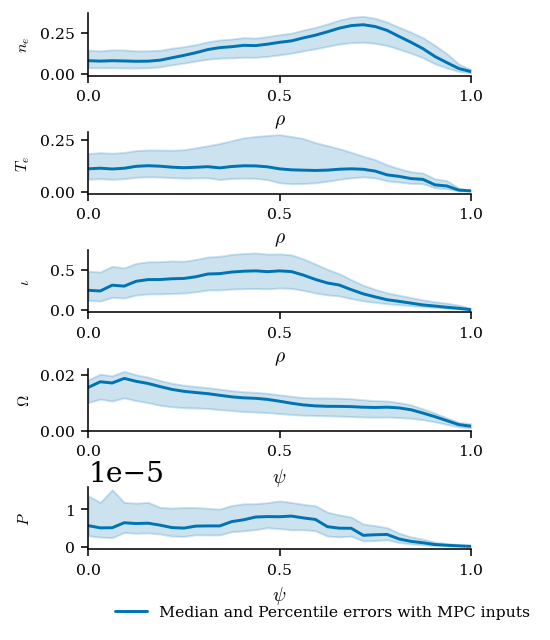

In [70]:
plot_median_err(plot_baseline = False ,normalized = True)

In [ ]:
scenario['target_profile_names']

normalize by the average value of delta; do it over the entire dataset

In [ ]:
scenario['scalar_input_names']

## PCA Modes Analysis

In [80]:
profiles = scenario['target_profile_names']

train_generator = DataGenerator(traindata,
                                1,
                                profiles,
                                scenario['actuator_names'],
                                profiles,
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights=None)

In [91]:
from sklearn import preprocessing
from sklearn import decomposition

length = int(len(train_generator)/1000)
num_components=10
full_pca_fitters = {}
delta_pca_fitters = {}
std_dict ={}
std_deltas_dict = {}
iqr_dict = {}
iqr_deltas_dict = {}

for profile in profiles:
#     full = np.array([(train_generator[int(i/128)][0]['input_' + profile][int(i % 128)]+train_generator[int(i/128)][1]['target_' + profile][int(i % 128)]) for i in range(length)]).squeeze()
#     delta = np.array([train_generator[int(i/128)][1]['target_' + profile][int(i % 128)] for i in range(length)]).squeeze()
    full = np.array([(train_generator[i][0]['input_' + profile]+train_generator[i)][1]['target_' + profile]) for i in range(length)]).squeeze()
    delta = np.array([train_generator[i][1]['target_' + profile] for i in range(length)]).squeeze()
#     std_dict[profile] = np.std(full)
#     std_deltas_dict[profile] = np.std(delta)
#     iqr_dict[profile] = scipy.stats.iqr(full)
#     iqr_deltas_dict[profile] = scipy.stats.iqr(delta)
    
    print(profile, ' made arrays')
    full_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')
    delta_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(delta)
    print(profile, ' done deltas')


SyntaxError: invalid syntax (<ipython-input-91-18488fc0b4cc>, line 16)

In [57]:
full.shape

(947, 128, 128, 33)

In [ ]:
# import sklearn

# with open('/projects/EKOLEMEN/profile_predictor/full_pca_fitters.pkl','rb') as f:
#     full_pca_fitters = pickle.load(f, encoding='latin1')
# with open('/projects/EKOLEMEN/profile_predictor/delta_pca_fitters.pkl','rb') as f:
#     delta_pca_fitters = pickle.load(f, encoding='latin1')

In [20]:
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret

def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))

### Generate PCA Coefficients

In [98]:
# Set up to solve the MPC based on this train generator
# Need encoded states 
def get_conv_mpc_train(i):
    # Build MPC inputs
    n = scenario['lookahead']
    temp_x_real = {}
    temp_xf_real = {}
    temp_u_mpc = 0

    for sig in scenario['target_profile_names']:
        temp_x_real['input_' + sig] = train_generator[i][0]['input_' + sig].reshape((1,1,scenario['profile_length']))
        temp_xf_real['input_' + sig] = temp_x_real['input_' + sig] + train_generator[i][1]['target_' + sig].reshape((1,1,scenario['profile_length']))

    for sig in scenario['scalar_input_names']:
        temp_x_real['input_' + sig] = train_generator[i][0]['input_' + sig][-1][0].reshape((1,1,1))
        temp_xf_real['input_' + sig] = train_generator[i][0]['input_' + sig][-1][-1].reshape((1,1,1))


    temp_x = encode_state(state_encoder, temp_x_real)
    temp_xf = encode_state(state_encoder, temp_xf_real)

    #### Get MPC Solution

    N = temp_x.shape[0]
    M = u_enc_tot.shape[2]

    # Generate Q,R
    Q_scale = 1e5
    R_scale = 1e-10

    Q = np.eye(N)
    R = np.eye(M)
    Q = np.eye(N)*Q_scale
    R = np.eye(M)*R_scale

    n_prime = n

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,temp_x,temp_xf,n_prime, lim = 2)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc = sol_mpc.reshape(n_prime, M)
    temp_u_mpc = u_mpc
    
    ### Build Conv Model Predictions
    conv_pred_profiles = {}
    temp_prof = predict_model_train(i, umpc = temp_u_mpc)
#     print(temp_prof)
    for j, sig in enumerate(scenario['target_profile_names']):
#         conv_pred_profiles[sig] = np.squeeze(predict_model_train(i, umpc = temp_u_mpc)[j])
        conv_pred_profiles[sig] = np.squeeze(temp_prof[j])
    return conv_pred_profiles


def predict_model_train(i, umpc = None):
    i = 0; umpc = None;

    inp = []

    for sig in scenario['target_profile_names']:
        inp.append((train_generator[i][0]['input_' + sig].reshape((1,1,scenario['profile_length']))))



    for sig in scenario['actuator_names']:
        inp.append(np.array([np.squeeze(train_generator[i][0]['input_past_' + sig])]))

    for sig in scenario['actuator_names']:
        if umpc is not None:
            inp.append(umpc)
        else:
            inp.append(np.array([np.squeeze(train_generator[i][0]['input_future_' + sig])]))

    for sig in scenario['scalar_input_names']:
        inp.append(np.array([np.squeeze(train_generator[i][0]['input_' + sig])]))

    return np.array(model.predict(inp))

In [99]:
get_conv_mpc_train(i)

[[ 1.99999941  2.         -0.91475765  1.69608441]
 [ 1.63322474  2.          0.68565637  1.99999995]
 [ 1.49405887  1.99999999  0.83527813  1.99999996]
 [ 0.99611689  1.99999999  1.228473    1.99999986]]


{'dens': array([0.14723875, 0.13754551, 0.1292147 , 0.13498342, 0.13586046,
        0.15238163, 0.16916366, 0.19967863, 0.19960478, 0.20126706,
        0.20116794, 0.20513721, 0.22477798, 0.25128603, 0.27263343,
        0.2920326 , 0.3133299 , 0.32645494, 0.35057905, 0.36293042,
        0.379002  , 0.4017524 , 0.4167279 , 0.43586504, 0.44855458,
        0.45830384, 0.4621879 , 0.447927  , 0.40174854, 0.32419783,
        0.22799253, 0.13830526, 0.06700743], dtype=float32),
 'temp': array([ 0.40898865,  0.41424155,  0.39616746,  0.3785009 ,  0.36170167,
         0.34520614,  0.33228415,  0.3178311 ,  0.30692536,  0.2904377 ,
         0.2735551 ,  0.25641263,  0.24264368,  0.2319872 ,  0.2179541 ,
         0.21409172,  0.20336244,  0.19778877,  0.19125195,  0.18551111,
         0.18917534,  0.18520282,  0.1873604 ,  0.18859911,  0.20154263,
         0.19654799,  0.18192089,  0.17730038,  0.17393544,  0.09248678,
         0.08675202,  0.01172423, -0.02497236], dtype=float32),
 'q_EFIT01': 

In [ ]:
conv_pred_profiles_arr = []

for i in range(0, length):
    conv_pred_profiles_arr.append(get_conv_mpc_train(i))
    print('{}/{}'.format(i,length),end='\r')


In [75]:
# Saving the statistics to file:
# with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/train_conv_pred.pkl', 'wb') as f:
#     pickle.dump([conv_pred_profiles_arr], f)

# # Getting back the statistics:
with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/train_conv_pred.pkl', 'rb') as f:
    conv_pred_profiles_arr = pickle.load(f)

In [88]:
fitter = full_pca_fitters
scalarize_functions = [scalarize_mean, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names = [fun.__name__[10:] for fun in scalarize_functions]
profiles = scenario['target_profile_names']
num_samples = length

In [90]:
fitter[profile]

KeyError: 'dens'

In [89]:


all_true_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
all_predicted_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}

n=1
nmax = len(profiles)*num_samples*len(scalarize_functions)
for j,profile in enumerate(profiles):
    for k in range(length):
        conv_pred_profiles = get_conv_mpc_train(k)
        target = np.squeeze(train_generator[k][0]['input_' + profile] + train_generator[k][1]['target_' + profile])[np.newaxis,:]
        pred = np.squeeze(conv_pred_profiles_arr[0][k][profile] + train_generator[k][0]['input_' + profile])[np.newaxis,:]
#         target = np.squeeze(train_generator[k][1]['target_' + profile])[np.newaxis,:]
#         pred = np.squeeze(conv_pred_profiles_arr[k][profile])[np.newaxis,:]
        
        for i,scalarize in enumerate(scalarize_functions):
            all_true_delta[profile][scalarize_function_names[i]][k] = scalarize(target, fitter=fitter[profile])
            all_predicted_delta[profile][scalarize_function_names[i]][k] = scalarize(pred, fitter=fitter[profile])  
            print('{}/{}'.format(n,nmax),end='\r')
            n += 1


KeyError: 'dens'

In [95]:
# Saving the statistics to file:
# with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/pca_stats.pkl', 'wb') as f:
#     pickle.dump([all_true_delta, all_predicted_delta], f)

# # Getting back the statistics:
# all_true_delta = 0
# all_predicted_delta = 0
# with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/batch_run/pca_stats.pkl', 'rb') as f:
#     all_true_delta, all_predicted_delta = pickle.load(f)
    
# # Getting back the statistics:
all_true_delta = 0
all_predicted_delta = 0
with open('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/batch_run/pca_stats_20.pkl', 'rb') as f:
    all_true_delta, all_predicted_delta = pickle.load(f)

In [93]:
scalarize_function_names

['mean', 'pca_1', 'pca_2']

### Plot

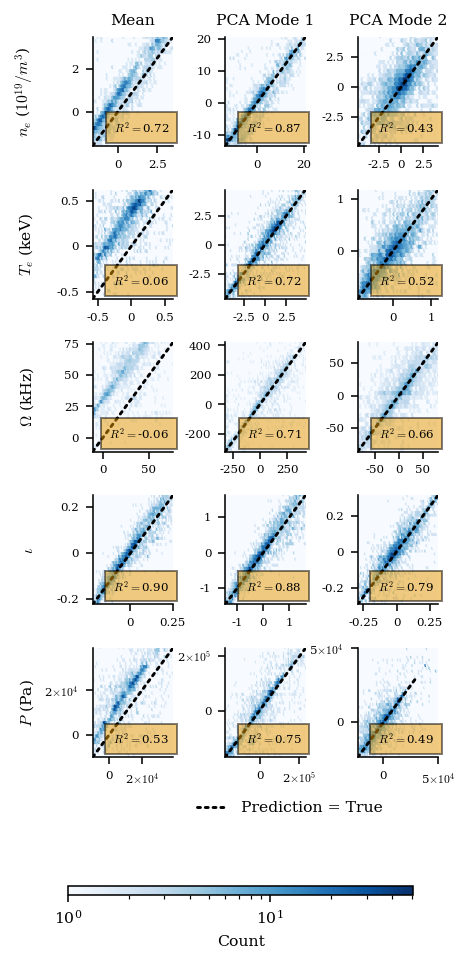

In [97]:
"""Scatter plot of deltas"""
from sklearn.metrics import r2_score

def my_formatter(x, pos):
    if abs(x - int(x))< np.finfo(np.float32).eps:
        return str(int(x))
    else:
        return str(np.around(x,3))

formatter = matplotlib.ticker.FuncFormatter(my_formatter)

profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(3.5,7))

for i,profile in enumerate(profiles):
    for j,name in enumerate(scalarize_function_names):

        pred=copy.deepcopy(all_predicted_delta[profile][name])
        true=copy.deepcopy(all_true_delta[profile][name])

        ax = axes[i,j]
        
        if name != 'mean':
            pred -= np.mean(pred)
            true -= np.mean(pred)
        
#         pred = helpers.normalization.denormalize_arr(pred,scenario['normalization_dict'][profile])
#         true = helpers.normalization.denormalize_arr(true,scenario['normalization_dict'][profile])

        
        pred *= scenario['normalization_dict'][profile]['iqr']
        true *= scenario['normalization_dict'][profile]['iqr']
        
        bounds = find_bounds(true,pred,95)
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

        r2_model = r2_score(true,pred)
        r2_baseline = r2_score(true, np.zeros(true.shape))

        hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
        ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_model), fontsize=6, horizontalalignment='right',verticalalignment='bottom', 
                transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[-1], alpha=0.5))

        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k', linestyle=':',lw=1.5,label='Prediction = True')

        if i==0:
            ax.set_title(scatter_titles[name], size=8)

        if j in [0]:
            ax.set_ylabel(labels[profile], size=8)

        ax.tick_params(axis='both', which='major', labelsize=6)
#         ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_formatter(formatter)
        ax.yaxis.set_minor_formatter(formatter)


axes[4,0].set_yticks([0,20000])
axes[4,0].set_yticklabels(['0',r'2$\times 10^4$'])
axes[4,0].set_xticks([0,20000])
axes[4,0].set_xticklabels(['0',r'2$\times 10^4$'])

axes[4,1].set_yticks([0,200000])
axes[4,1].set_yticklabels(['0',r'2$\times 10^5$'])
axes[4,1].set_xticks([0,200000])
axes[4,1].set_xticklabels(['0',r'2$\times 10^5$'])

axes[4,2].set_yticks([0,50000])
axes[4,2].set_yticklabels(['0',r'5$\times 10^4$'])
axes[4,2].set_xticks([0,50000])
axes[4,2].set_xticklabels(['0',r'5$\times 10^4$'])

plt.subplots_adjust(hspace=0.4,wspace=0.65,bottom=0.15, left=0.2)

fig.align_ylabels(axes[:,0])



cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', fraction=.3)
cb.set_label('Count', size=8)
cb.ax.tick_params(labelsize=8)

# fig.legend(handles=axes[0,0].lines,     
#            labels=[line._label for line in axes[0,0].lines],  
#            loc="upper center",
#            bbox_to_anchor=(0.5, 0.15),
#            frameon=False,
#            mode=None,
#            ncol=2,
#            fontsize=8);
fig.legend(handles=axes[0,0].lines,     
           labels=[line._label for line in axes[0,0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.12),
           frameon=False,
           mode=None,
           ncol=1,
          fontsize=8)
# fig.savefig('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/all_pca_acc.pdf',bbox_inches='tight',pad_inches=0.1)
fig.savefig('/home/aiqtidar/plasma-profile-predictor/Controls/Saved_stats/all_pca_acc.png',bbox_inches='tight',pad_inches=0.1)

In [ ]:
pred[0]

In [ ]:
scatter_titles

## Neo MPC System

In [18]:
def lqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:
    from scipy.linalg import solve_discrete_are
    return solve_discrete_are(A, B, Q, R) 

def solve_Neo_MPC_system(Q,R,A,B,x0,xf,n, lim = 2):
    
    # Imports
    import numpy
    from cvxopt import matrix
    from cvxopt import solvers
    
    # Define parameters
    N = A.shape[0]
    M = B.shape[1]
#     print("N: {}".format(N))
#     print("M: {}".format(M))
    
    # Reshape to avoid complications
    x0 = x0.reshape((N,1))
    xf = xf.reshape((N,1))

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]
    
#     print("M_bar: {}".format(M_bar))
    
    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n-1):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]
    
    Q_N = lqr(A,B,Q,R)
    rsl = slice((n-1) * N, n * N)
    Q_bar[rsl, rsl] = Q_N
    
#     print("Q_bar: {}".format(Q_bar))

    # Generate R_bar
    R_bar = np.kron(np.eye(n),R)
    
#     print("R_bar: {}".format(R_bar))

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]
    
#     print("V: {}".format(V))
        
    # Generate L
    L = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    L[rsl, :N] = A #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        L[rsl, :N] = L[rsl_p, :N]
        L[rsl, N : (i + 1) * N] = A @ L[rsl_p, : i * N]
    
#     print("L: {}".format(np.matrix.view(L)))
    
    #Generate X_F from x_f
    X_F = np.zeros((N*n,1))
    
    for i in range(0,n):
        rsl = slice(i * N, (i + 1)*N)
        X_F[rsl] = xf
    
#     print("XF: {}".format(X_F))
    
    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on U
    d[rsl,:] = np.ones((M*n,1))*lim
    d[slice(M*n,2*M*n),:] = np.ones((M*n,1))*lim

#     print("D_bar: {}".format(D_bar))
#     print("D: {}".format(d))
    
    # Generate F and H matrices   
    temp = np.transpose(V) @ (Q_bar)
    F = temp @ (M_bar.dot(x0) - X_F) # + L @ (X_F)
    
    temp = np.transpose(V) @ (Q_bar)
    H = temp @ (V) + R_bar
    
#     print("H: {}".format(H))
#     print("F: {}".format(F))

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)

    P = matrix(H, tc='d')
    q = matrix(F, tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')

    ######################################### Print Solution ###############################
    # Suppress Output
    solvers.options['show_progress'] = False
    
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q, G, h);

    return sol

## Solve MPC Problem for one case

### Set up Q,R

In [ ]:
# 0 <= Sample < 9701
sample = 10

x0 = X_0_enc_tot[sample] 
xf = X_F_enc_tot[sample]

N = x0.shape[0]
M = u_enc_tot.shape[2]

# Generate Q,R
Q = np.eye(N)*1e5
R = np.eye(M)*1e-3

# Replenish A,B
# A,B = get_AB(model)

n = scenario['lookahead']
# print("N: {}".format(N))
# print("M: {}".format(M))
# print("n: {}".format(n))
# print("Q: {}".format(np.matrix.view(Q)))
# print("R: {}".format(np.matrix.view(R)))

sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x0,xf,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(n, M)

control_inputs_in_real_space(u_enc_tot[sample], u_mpc)

In [ ]:
# Compare stats
tempx = X_0_enc_tot[sample]
tempx_mpc = tempx

for i in range (0,n):
    tempx = tempx @ A.T  + u_enc_tot[sample][i] @ B.T
    tempx_mpc = tempx_mpc @ A.T  + u_mpc[i] @ B.T
    
diff = np.abs(X_F_enc_tot[sample] - tempx_mpc)
(diff/np.mean(X_F_enc_tot[sample]))*100

In [ ]:
X_F_enc_tot[sample]

### Decoding and comparing Control Inputs

In [ ]:
def control_inputs_in_real_space(u_actual, u_mpc = None):    
    A1_inv, A2_inv, B1, B2 = get_control_decoder_matrices(control_encoder)
    u_actual_dec = decode_control(A1_inv, A2_inv, B1, B2, u_actual);
    print(scenario_auto['actuator_names'])
    print('Actual inputs: {}'.format(helpers.normalization.denormalize_arr(u_actual_dec,scenario['normalization_dict'][profile])))
    if u_mpc is not None:
        u_mpc_dec = decode_control(A1_inv, A2_inv, B1, B2, u_mpc);
        print('MPC inputs: {}'.format(helpers.normalization.denormalize_arr(u_mpc_dec,scenario['normalization_dict'][profile])))
# helpers.normalization.denormalize_arr(u_dec,scenario['normalization_dict'][profile])

In [ ]:
control_inputs_in_real_space(u_enc_tot[sample], u_mpc)

In [ ]:
u_tot[0];

In [ ]:
tempu = {}
for key in scenario['actuator_names']:
    tempu[key] = helpers.normalization.denormalize_arr(u_tot[0]['input_' + key],scenario['normalization_dict'][profile])
# helpers.normalization.normalize(tempu,scenario_auto['normalization_dict'][profile])
    helpers.normalization.normalize_arr(tempu[key],scenario_auto['normalization_dict'][profile][key],uniform_over_profile=True)
tempu

### Denormalized Versions

In [ ]:
# A1_inv, A2_inv, B1, B2 = get_control_decoder_matrices(control_encoder)
u_mpc_dec = decode_control(A1_inv, A2_inv, B1, B2, u_mpc);
print("MPC inputs: {}".format(helpers.normalization.denormalize_arr(u_mpc_dec,scenario_auto['normalization_dict'][profile])))

u_real_dec = decode_control(A1_inv, A2_inv, B1, B2, u_enc_tot[sample]);
print("Real inputs: {}".format(helpers.normalization.denormalize_arr(u_real_dec,scenario_auto['normalization_dict'][profile])))


## Plots

### Plot u vs time

In [ ]:
plt.plot(sol_mpc)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("u")
plt.xlabel("# Timestep")
plt.show()

### Plot how state changes

In [ ]:
states = []
abs_diff = []
abs_fin_diff = []
abs_aut_diff = []
x_prev = x0
x_prev2 = x0

for i in range(0,n):
    x_new = (A @ x_prev) + np.transpose(B.dot(u_mpc[i]))
    x_new2 = (A @ x_prev2) + np.transpose(B.dot(u_enc_tot[sample][i]))    
    
    print("x[{}]: {} \n".format(i+1,x_new))

    states.append(x_prev)
    abs_diff.append(np.linalg.norm(x_new - x_prev))
    abs_fin_diff.append(np.linalg.norm(x_new - xf))
    abs_aut_diff.append(np.linalg.norm(x_new2 - xf))
    x_prev = x_new
    x_prev2 = x_new2

print("Target: {} \n".format(xf))
    

In [ ]:
plt.clf()
plt.plot(np.arange(1,n+1),abs_fin_diff)
plt.plot(np.arange(1,n+1),abs_aut_diff)
plt.legend(["Abs Diff between x_i and x_f", "Abs Diff between x_i and x_f in Autoencoder"])
plt.ylabel("Norm of (x_i+1 - x_i) ")
plt.xlabel("# Timestep")
plt.show()

# Generate Larger results

In [ ]:
# Generate Q,R
Q = np.eye(N)*1e5
R = np.eye(M)*1e-3

# Replenish A,B
# A,B = get_AB(model)

n = scenario['lookahead']

#### Pick Sample and solve system

# 0 <= Sample < 9701
# Pick n_sample random samples and put them into an array called sample
n_sample = 8
sample = []

for i in range(0, n_sample):
    sample.append(np.random.randint(100))

# Solve mpc system for the samples in sample array
u_mpc = []
for samp in sample:
    x0 = X_0_enc_tot[samp] 
    xf = X_F_enc_tot[samp]

    N = x0.shape[0]
    M = u_enc_tot.shape[2]

    sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x0,xf,n)
    sol_mpc = np.array(sol_mpc['x'])
    u_mpc.append(sol_mpc.reshape(n, M))

# Generate statistics for each sample
abs_diff_tot = []
abs_aut_diff_tot = []

for j in range(0,len(sample)):
    states = []
    abs_diff = []
    abs_aut_diff = []
    x_prev = X_0_enc_tot[sample[j]]
    x_prev2 = X_0_enc_tot[sample[j]]
    xf = X_F_enc_tot[sample[j]]

    for i in range(0,n):
        x_new = (A @ x_prev) + np.transpose(B.dot(u_mpc[j][i]))
        x_new2 = (A @ x_prev2) + np.transpose(B.dot(u_enc_tot[sample[j]][i]))    

        states.append(x_prev)
        abs_diff.append(np.linalg.norm(x_new - xf))
        abs_aut_diff.append(np.linalg.norm(x_new2 - xf))
        x_prev = x_new
        x_prev2 = x_new2
    abs_diff_tot.append(abs_diff)
    abs_aut_diff_tot.append(abs_aut_diff)


n_fig = 2
figures, axes = plt.subplots(nrows = int(len(sample) /2) + 1, ncols = n_fig, clear= True)

for k in range(0, len(sample)):
    for i in range(0, n_fig):
        for j in range(0, int(len(sample) /2) + 1):
            axes[j,i].plot(np.arange(1,n+1),abs_diff_tot[k])
            axes[j,i].plot(np.arange(1,n+1),abs_aut_diff_tot[k])
            axes[j,i].set_ylabel("||x_i+1 - x_f|| ")
            axes[j,i].set_xlabel("# Timestep")
    figures.tight_layout()
    figures.legend(["||x_i - x_f||", "||x_i - x_f|| in Autoencoder"])
    plt.show()
    figures.clear()

### Interpretation of Encoded state MPC results

The MPC is asked to find the set of control inputs $ U $ which take the state space system from some $x_i$ to some $x_f$, both of which are taken from real data. However, the state space model used by the MPC relies on the model used from the autoencoder system. 

The autoencoder model predicts some final state $x_f^a$ based on the actual set of inputs used during the experiment.

The MPC's final state $x_f^m$ is in fact closer to the real state $x_f$ than $x_f^a$.

There are numerous possibilities:

1. There  are errors in the state space model from the autoencoder, which implies that the real set of inputs to reach $x_f$ are different from $U$.

2. The autoencoder's prediction $x_f^a$ in incorrect, and that the real state reached should be closer to $x_f$.

3. Both of the above?




# ETC